In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("../")

In [2]:
from sprintdl.main import *
from sprintdl.gans import *

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

# Define required

In [4]:
bs = 64
imsize = 64

fpath = Path("/media/hdd/Datasets/celeba/img_align_celeba/")

tfms = [make_rgb, ResizeFixed(imsize), to_byte_tensor, to_float_tensor]


splitter = partial(random_splitter, p_valid = .2)
label_func = lambda x: str(x).split("/")[-2]

In [5]:
data = quick_data(fpath, tfms, splitter, label_func, bs = bs, c_in = 3,max = 1000)

total items: 1000
n class : 1


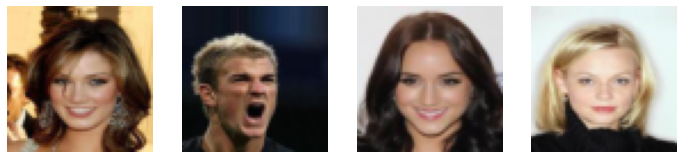

In [6]:
show_batch(data, 4)

# Actual

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


# callbacks

In [8]:
def genloss(x,y=None): return -torch.mean(x)

def discloss(x,y): return -(torch.mean(x) - torch.mean(y))
    

In [9]:
lr = 5e-4
# pct_start = 0.5
# phases = create_phases(pct_start)
# sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
# sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgGANStatsCallback,genloss),
#     partial(ParamScheduler, 'lr', sched_lr),
#     partial(ParamScheduler, 'mom', sched_mom),
    partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
#     MixUp,
       partial(CudaCallback, device)]

# Training

In [10]:
clear_memory()

In [11]:
latent = 1000
gen = Generator(latent, 3, imsize).cuda()
disc = Discriminator(3, imsize).cuda()
initialize_weights(gen)
initialize_weights(disc)
gen.train();
disc.train();

optd= torch.optim.RMSprop(disc.parameters(), lr=lr)
optg = torch.optim.RMSprop(gen.parameters(), lr=lr)

In [17]:
# learn = get_learner(nfs, data, lr, conv_layer, cb_funcs=cbfs)
# learn = Learner(arch,  data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

learn = GANLearner(
        disc,
        gen,
        data,
        discloss,
        genloss,
        opt_func_D=optd,
        opt_func_G=optg,
        lr=lr,
        splitter=param_getter,
#         cbs=None,
        cb_funcs=cbfs,
        device="cuda:0",
        latent_dim=latent,
        clip_value=0.01,
        n_critic=5)

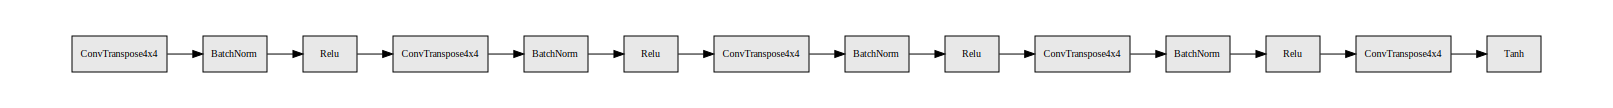

In [18]:
visualize_model(learn.model_G, [1,1000,64,64])

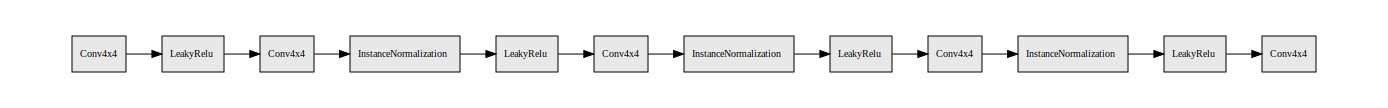

In [19]:
visualize_model(learn.model_D, [1,3,64,64])

In [20]:
learn.fit(1)

epoch,train_loss_D,train_loss_G,train_genloss,valid_loss_D,valid_loss_G,valid_genloss,time
0,0.431934,-0.906199,0.422800,0.574774,-1.201700,0.569916,00:09


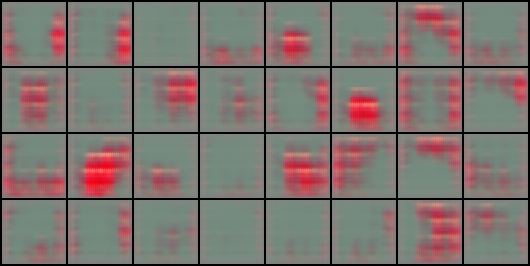

In [21]:
learn.plot_output()

In [22]:
learn.fit(20)

epoch,train_loss_D,train_loss_G,train_genloss,valid_loss_D,valid_loss_G,valid_genloss,time
0,0.443678,-1.113412,0.504238,0.534003,-1.056129,0.502979,00:09
1,0.653670,-1.339138,0.651791,0.590693,-0.787165,0.567391,00:09
2,0.645813,-1.276998,0.617319,0.382598,-1.133437,0.623665,00:09
3,0.692958,-1.398803,0.687525,0.660860,-1.182863,0.489590,00:09
4,0.719244,-1.475738,0.716701,0.674105,-1.151391,0.466318,00:09
5,0.717030,-1.476057,0.714895,0.715294,-1.480704,0.714089,00:09
6,0.686065,-1.416142,0.673482,0.716067,-1.480332,0.715315,00:09
7,0.646862,-1.306802,0.647836,0.700638,-1.415872,0.697835,00:09
8,0.566350,-1.348762,0.696554,0.583367,-0.931544,0.627803,00:09
9,0.701837,-1.421439,0.671532,0.724388,-1.493331,0.724801,00:09


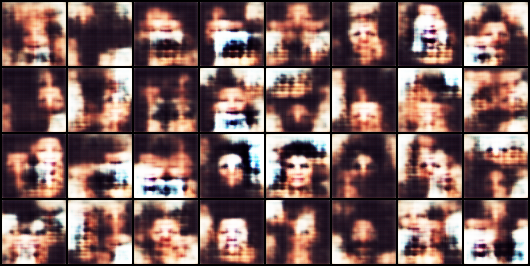

In [23]:
learn.plot_output()

In [24]:
learn.fit(20)

epoch,train_loss_D,train_loss_G,train_genloss,valid_loss_D,valid_loss_G,valid_genloss,time
0,0.633367,-1.179487,0.546534,0.644826,-1.128335,0.455491,00:09
1,0.635322,-1.298493,0.615231,0.598839,-1.053343,0.640914,00:09
2,0.586795,-1.232199,0.564189,0.544949,-0.602492,-0.117521,00:09
3,0.476061,-1.110455,0.576069,0.648050,-1.086409,0.440141,00:09
4,0.646566,-1.232188,0.587256,0.607329,-1.249085,0.630771,00:09
5,0.634890,-1.271390,0.606333,0.638758,-0.920457,0.256636,00:09
6,0.553664,-1.254702,0.632705,0.064600,-0.836366,0.569031,00:09
7,0.631428,-1.167826,0.563871,0.563801,-1.135851,0.635683,00:09
8,0.625566,-1.195228,0.593417,0.661213,-1.346023,0.656144,00:09
9,0.541766,-1.204432,0.624837,0.614700,-1.026333,0.339192,00:09


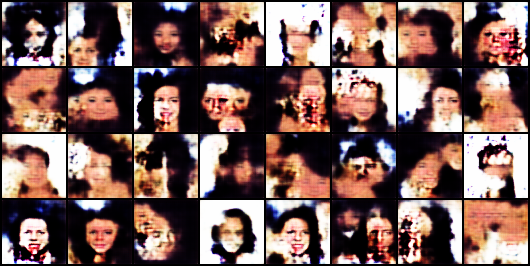

In [25]:
learn.plot_output()

In [26]:
learn.fit(20)

epoch,train_loss_D,train_loss_G,train_genloss,valid_loss_D,valid_loss_G,valid_genloss,time
0,0.541499,-1.102053,0.524540,0.596715,-1.115262,0.499232,00:09
1,0.572629,-1.059099,0.459121,0.529465,-1.102769,0.584687,00:09
2,0.543898,-1.044698,0.468357,0.641409,-1.133966,0.472080,00:09
3,0.573577,-1.186319,0.563982,0.528465,-0.842082,0.388845,00:09
4,0.477020,-1.007550,0.494415,0.594015,-1.014823,0.392893,00:09
5,0.551448,-1.036858,0.470097,0.498132,-1.081983,0.605841,00:09
6,0.551805,-1.033969,0.456342,0.603159,-1.007230,0.400764,00:09
7,0.560600,-1.033981,0.446869,0.585561,-0.902523,0.297394,00:09
8,0.468714,-1.034971,0.527447,0.333087,-0.886288,0.583938,00:09
9,0.489940,-0.973153,0.450130,0.512132,-1.086629,0.596744,00:09


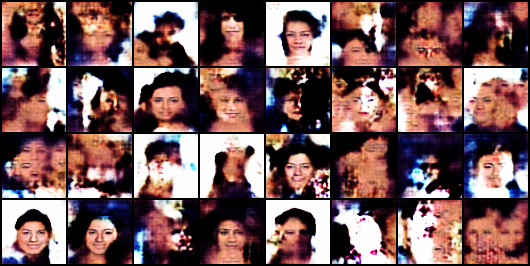

In [27]:
learn.plot_output()

In [28]:
learn.fit(20)

epoch,train_loss_D,train_loss_G,train_genloss,valid_loss_D,valid_loss_G,valid_genloss,time
0,0.472003,-1.014054,0.491085,0.531304,-0.846018,0.274534,00:09
1,0.524147,-0.974249,0.414625,0.360235,-0.905672,0.512776,00:09
2,0.546848,-0.991451,0.444310,0.565289,-0.847601,0.228492,00:09
3,0.524041,-0.911933,0.368773,0.248513,-0.892541,0.513584,00:09
4,0.504838,-0.905881,0.385967,0.599483,-1.012674,0.416801,00:09
5,0.523368,-0.978125,0.451176,0.556461,-0.740137,0.133414,00:09
6,0.503731,-0.945805,0.434272,0.494907,-1.075874,0.547899,00:09
7,0.498068,-0.899448,0.386067,0.553074,-0.955537,0.385141,00:09
8,0.515534,-0.949900,0.429622,0.581243,-0.708836,0.072968,00:09
9,0.425906,-0.907731,0.445866,0.371755,-0.848945,0.525353,00:09


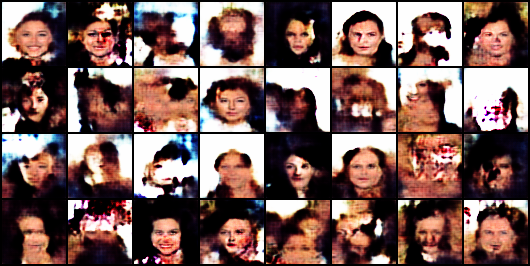

In [29]:
learn.plot_output()

In [ ]:
learn.recorder_gan.plot_lr()

In [ ]:
learn.recorder_gan.plot_loss()

In [ ]:
learn.plot_output()

In [ ]:
learn.fit(30)
learn.plot_output()